In [27]:
import bilby
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns

from gw_smc_utils.plotting import set_style

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

lal.swig_redirect_standard_output_error(False)

os.environ["OMP_NUM_THREADS"] = "1"

set_style()

In [28]:
figure_dir = pathlib.Path("figures")
figure_dir.mkdir(exist_ok=True)

In [2]:
duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20

outdir = "outdir"
label = "temperature_example"
bilby.core.utils.setup_logger(outdir=outdir, label=label, log_level="WARNING")


In [3]:
# GW150914-like injection
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=3000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)
injection_parameters = bilby.gw.conversion.generate_all_bbh_parameters(
    injection_parameters
)

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_zero_noise(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    # "phase",
    "luminosity_distance",
    "theta_jn",
]:
    priors[key] = injection_parameters[key]

priors.validate_prior(duration, minimum_frequency)

priors["chirp_mass"] = bilby.core.prior.Uniform(25, 30)
priors["mass_ratio"] = bilby.core.prior.Uniform(0.125, 1)
priors.pop("mass_1")
priors.pop("mass_2")

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
    phase_marginalization=True,
)


In [ ]:
def log_likelihood(theta):
    likelihood.parameters.update(theta)
    return likelihood.log_likelihood()

# Define grid
n = 100
chirp_mass_vec = np.linspace(25, 30, 100)
mass_ratio_vec = np.linspace(0.125, 1, 100)
chirp_mass, mass_ratio = np.meshgrid(chirp_mass_vec, mass_ratio_vec)
chirp_mass = chirp_mass.flatten()
mass_ratio = mass_ratio.flatten()
theta = priors.sample(len(chirp_mass))
theta["chirp_mass"] = chirp_mass
theta["mass_ratio"] = mass_ratio
theta_df = pd.DataFrame(theta)
theta_list = theta_df.to_dict(orient="records")

# Adjust processes here if needed
with mp.Pool(processes=4) as pool:
    logl = np.array(pool.map(log_likelihood, theta_list))

logp = priors.ln_prob(theta, axis=0) 


16:36 bilby WARNING : Prior sampling efficiency is very low, please verify its validity.


In [11]:
betas = np.array([1e-2, 1e-1, 0.5, 1.0])

weights = []
for beta in betas:
    logw = beta * logl + logp
    logw -= np.max(logw)
    w = np.exp(logw)
    weights.append(w)

weights = np.array(weights)

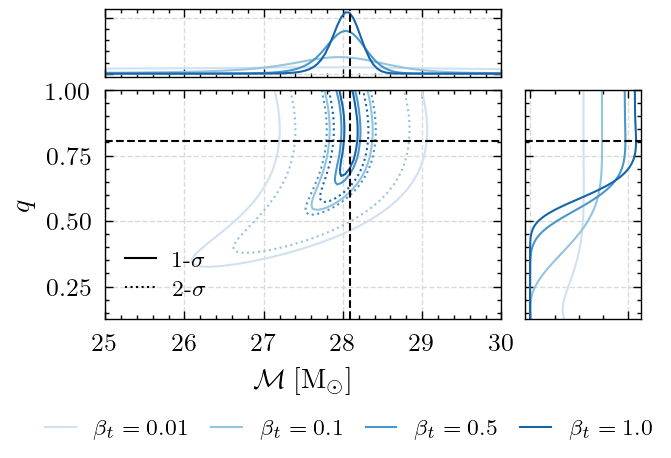

In [30]:
fig = plt.figure()
gs = fig.add_gridspec(4, 4)
ax_joint = fig.add_subplot(gs[1:4, 0:3])
ax_marg_x = fig.add_subplot(gs[0, 0:3], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1:4, 3], sharey=ax_joint)

linestyles = [":", "-"]
colours = sns.color_palette("Blues", len(betas))

legend_handles = []

for beta, w, c in zip(betas, weights, colours):
    # ax.scatter(theta["chirp_mass"], theta["mass_ratio"], c=w)

    mass_ratio_grid = mass_ratio.reshape(n, n)
    chirp_mass_grid = chirp_mass.reshape(n, n)
    w_grid = w.reshape(n, n)

    n_levels = 2
    cc = n_levels * [c]
    ax_joint.contour(
        chirp_mass_grid,
        mass_ratio_grid,
        w_grid,
        levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
        colors=cc,
        linestyles=linestyles,
        negative_linestyles="-.",
    )

    marg_chirp_mass = np.sum(w_grid, axis=0)
    marg_mass_ratio = np.sum(w_grid, axis=1)
    marg_chirp_mass /= np.sum(marg_chirp_mass)
    marg_mass_ratio /= np.sum(marg_mass_ratio)

    ax_marg_x.plot(chirp_mass_grid[0, :], marg_chirp_mass, color=c)
    ax_marg_y.plot(marg_mass_ratio, mass_ratio_grid[:, 0], color=c)

    legend_handles.append(
        Line2D(
            [0],
            [0],
            color=c,
            linestyle="-",
            label=r"$\beta_t={}$".format(beta),
        )
    )
    
# ax_marg_x.set_yticklabels([])
# ax_marg_y.set_xticklabels([])

ax_marg_x.tick_params(labelbottom=False)
ax_marg_x.tick_params(labelleft=False)
ax_marg_y.tick_params(labelleft=False)
ax_marg_y.tick_params(labelbottom=False)

ax_joint.set_xlabel(r"$\mathcal{M} \;[{\rm M}_{\odot}]$")
ax_joint.set_ylabel(r"$q$")


ax_joint.axvline(
    injection_parameters["chirp_mass"],
    color="k",
    linestyle="--",
)
ax_joint.axhline(
    injection_parameters["mass_ratio"],
    color="k",
    linestyle="--",
)

ax_marg_x.axvline(
    injection_parameters["chirp_mass"],
    color="k",
    linestyle="--",
)

ax_marg_y.axhline(
    injection_parameters["mass_ratio"],
    color="k",
    linestyle="--",
)


fig.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.025),
    ncol=4,
)

ax_joint.legend(
    handles=[
        Line2D([0], [0], color="k", linestyle="-", label="1-$\sigma$"),
        Line2D([0], [0], color="k", linestyle=":", label="2-$\sigma$"),
    ]
)

plt.show()
fig.savefig(figure_dir / "chirp_mass_mass_ratio_temperature.pdf", bbox_inches="tight")

